In [327]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [14]:
animal_df = pd.read_csv('Datasets/Animal-Info.csv')

In [268]:

def remove_na(df):
    temp = df
    for column in temp.columns:
        temp = temp[(temp[column] != 'Varies') & (temp[column] != 'Not Applicable')]
    return temp

def clean_column(item):
    item = item.replace(',', '')
    if item[-1] == 'm':
        split = item.split()
        item = f'{' '.join(split[:2])} {float(split[2][:-1])*1000}'
    if item.count('tons') > 0:
        split = item.split()
        item = f'{' '.join(split[:2])} {float(split[2])*1000}'
        
    out = 0
    split = item.replace(' ', '-').split('-')
    if item.count('-') > 0:
        out = (float(split[0]) + float(split[1]))/2
    if item.count('Up to') > 0:
        out = float(item.split()[-1])/2
    if split[-1] == 'months':
        out *= 30
    if split[-1] == 'weeks':
        out *= 7
    only_nums = lambda x: ''.join([i for i in x if i.isnumeric()])
    
    return out if out else float(only_nums(item))

def normalize(nums):
    nums = np.log(nums)
    return (nums - np.mean(nums))/np.std(nums)

In [269]:
clean = remove_na(animal_df)
columns_to_clean = ['Height (cm)', 'Weight (kg)', 'Lifespan (years)', 
                    'Average Speed (km/h)', 'Top Speed (km/h)', 
                    'Gestation Period (days)']

for column in columns_to_clean:
    category = ' '.join(column.split()[:-1])
    clean = clean.assign(**{category: clean[column].apply(clean_column)})
    clean = clean.assign(**{f'Normal {category}': normalize(clean[category])})

clean.to_csv('Datasets/Clean-Animal-Info.csv')

In [348]:
inputs = ['Normal Height', 'Normal Weight']
outputs = ['Normal Lifespan']
input_tensors = torch.tensor(np.array(clean[inputs]), dtype=torch.float)
output_tensors = torch.tensor(np.array(clean[outputs]), dtype=torch.float)
X_train, X_test, Y_train, Y_test = train_test_split(input_tensors, output_tensors, test_size=0.1)

In [349]:
BATCH_SIZE = 8
LAYERS = [len(inputs), 10, 10, 10, len(outputs)]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [350]:
class CustomDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
        
    def __len__(self):
        return self.inputs.shape[0]
    
    def __getitem__(self, idx):
        input = self.inputs[idx]
        output = self.outputs[idx]
        return input, output

In [351]:
train_ds = CustomDataset(X_train, Y_train)
test_ds = CustomDataset(X_test, Y_test)

train_dl = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE)
test_dl = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE)

In [352]:
class Network(nn.Module):
    def __init__(self, dims, stack=None):
        super().__init__()
        if stack:
            self.stack = stack
        else:
            self.stack = nn.Sequential(nn.Dropout(p=0.1))
            for i in range(len(dims)-1):
                self.stack.append(nn.Linear(dims[i], dims[i+1]))
                if i != len(dims)-2:
                    self.stack.append(nn.ReLU())
                    self.stack.append(nn.Dropout(p=0.05))
                    
    def forward(self, x):
        x = x.view(-1, len(inputs))
        return self.stack(x)

In [353]:
def run(X, Y, model, loss):
    X, Y = X.to(device), Y.to(device)
    y_pred = model(X)
    y_pred, Y = y_pred.cpu(), Y.cpu()
    error = loss(y_pred, Y)
    return error

def train_epoch(model, optimizer, loss):
    model.train()
    errors = []

    for X, Y in train_dl:
        error = run(X, Y, model, loss)
        errors.append(error.item())

        optimizer.zero_grad()
        error.backward()
        optimizer.step()

    return np.mean(errors)

def evaluate(model, loss):
    model.eval()
    errors = []
    
    with torch.no_grad():
        for X, Y in test_dl:
            error = run(X, Y, model, loss)
            errors.append(error.item())
    
    return np.mean(errors)

In [354]:
def Train(learn_rate=0.001, epochs=30, plot_info=True):
    network = Network(LAYERS)
    network = network.to(device)
    loss_fn = nn.MSELoss()

    optimizer = optim.Adam(network.parameters(), lr = learn_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    train_errors = []
    test_errors = []

    for epoch in (bar := tqdm(range(epochs))):
        batch_error = train_epoch(network, optimizer, loss_fn)
        train_errors.append(batch_error)

        test_error = evaluate(network, loss_fn)
        test_errors.append(test_error)
        
        bar.set_description(f'Error: {test_error:.2f}')

        # scheduler.step()

    if plot_info:
        fig, error = plt.subplots(figsize=(14, 5))

        error.plot(train_errors)
        error.plot(test_errors)
        error.legend(['Train', 'Test'])
        error.set_xlabel('Epochs')
        error.set_ylabel('Error')
        error.set_title(f'Train Error: {train_errors[-1]:.2f} Test Error: {test_errors[-1]:.2f}')

    return network

Error: 0.60: 100%|██████████| 100/100 [00:02<00:00, 36.69it/s]


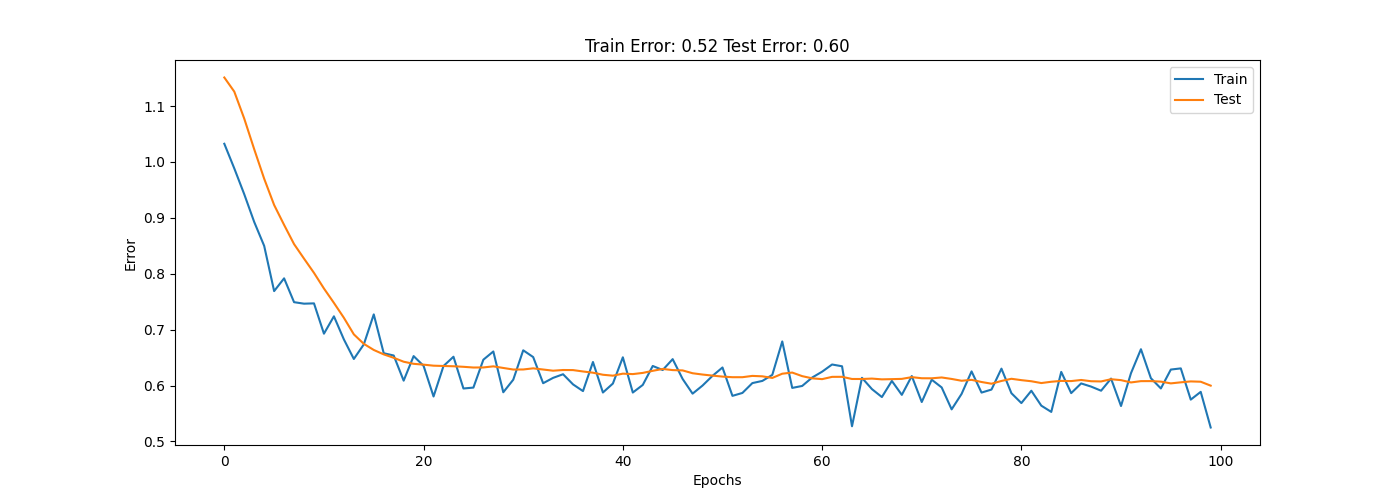

In [355]:
network = Train(epochs=100)

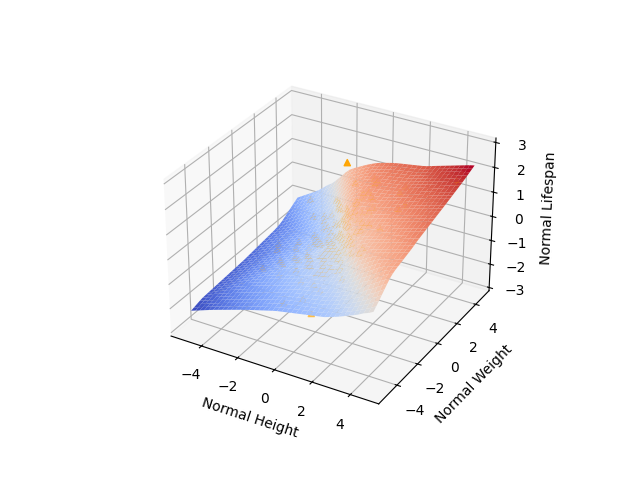

In [360]:
def show_plot(x, y, z, show_pred=False, show_terrain=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    if show_pred:
        if show_terrain:
            start_X = np.arange(-5, 5, 0.25)
            start_Y = np.arange(-5, 5, 0.25)
            X, Y = np.meshgrid(start_X, start_Y)
            X = torch.tensor(X, dtype=torch.float)
            Y = torch.tensor(Y, dtype=torch.float)
        
        network.eval()
        with torch.no_grad():
            if show_terrain:
                Z = network(torch.stack((X, Y), dim=2).reshape(-1, 2)).numpy().reshape(len(start_X), len(start_Y))
                ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
            else:
                Z = network(torch.tensor(np.array(clean[[x, y]]), dtype=torch.float)).numpy()
                ax.scatter(clean[x], clean[y], Z, marker='o')
        
    ax.scatter(clean[x], clean[y], clean[z], marker='^', color='orange')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    plt.show()
    
show_plot('Normal Height', 'Normal Weight', 'Normal Lifespan', show_pred=True, show_terrain=True)